Pre-requisites that you need to install before use

<!-- I might miss out a few -->
pip install tensorflow
pip instal scikit-learn
pip install keras
pip install keras-tuner
pip install matplotlib
pip install opencv-python
pip install scipy

Imports

In [12]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import keras_tuner as kt
import seaborn as sns

Using TensorFlow backend


In [26]:
def pre_processing_from_dir(dataset_dir, class_labels_dict, training=False):
    # Initialize lists to store images and labels
    images = []
    labels = []
    class_labels = []

    # Get a list of all subdirectories (each subdirectory represents a class)
    class_directories = os.listdir(dataset_dir)

    # Iterate through each subdirectory (class directory)
    for class_directory in class_directories:
        class_label = class_directory  # Use the directory name as the class label
        
        class_labels.append(class_label)
        class_path = os.path.join(dataset_dir, class_directory)

        # Get a list of image files in the class directory
        image_files = glob.glob(os.path.join(class_path, "*.jpg"))  # You may need to adjust the file extension

        # print(image_files)

        # Iterate through image files in the class directory
        for image_file in image_files:
            # Load and preprocess the image
            image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (28, 28))
            image = image / 255.0  # Normalize pixel values

            # plt.imshow(image, cmap=plt.cm.binary)

            # Append the preprocessed image and its label to the lists
            images.append(image)
            labels.append(class_label)

    # Convert lists to NumPy arrays
    images = np.array(images)

    if training:

        label_encoder = LabelEncoder()

        # Encode class labels using LabelEncoder
        labels = label_encoder.fit_transform(labels)

        for i in range(len(class_labels)):
            class_labels_dict[class_labels[i]] = i


        labels = np.array(labels, dtype="int64")

        # comment the below 2 lines if doing label-encoding
        # One-hot encode labels (need to do one code in order to fit into the model)
        num_classes = len(class_labels)
        labels = to_categorical(labels, num_classes=num_classes)

        return images, labels, class_labels, class_labels_dict

    else:

        # label-encoding done on test data should correspond to the ones in training data
        # this is to account for times when test data is lesser than training data

        for i in range(len(labels)):
            labels[i] = class_labels_dict[labels[i]]

        labels = np.array(labels, dtype="int64")

        # comment the below 2 lines if doing label-encoding
        # One-hot encode labels (need to do one code in order to fit into the model)
        num_classes = len(class_labels_dict)
        labels = to_categorical(labels, num_classes=num_classes)

        return images, labels, class_labels

ONLY RUN THE MODEL ON <b>TRAINING DATA</b>
- IF training data never change, no need to keep running it because we saved the model already.

In [7]:
def math_model(images, labels, num_classes, model_name):

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    # Define your CNN model for multi-class classification

    model = Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    # for one-hot encoding
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # uncomment this if using label-encoding, & comment the one above
    # model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # epochs is left at 20 for now, NEED TO CHANGE & decide how many epoch gives better accuracy
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

    # Save the trained model for later use
    model.save(f"{model_name}.keras")

    # not a must to return history here but it's to see whether model is overfitting or underfitting after training
    # can remove history once we confirmed model is good
    return f"{model_name}.keras", history, X_test, y_test

In [65]:
def math_reports(model, X_test, y_test, test_class_labels, train_class_labels):

    # Load the saved model
    loaded_model = load_model(model)

    predicted_y = loaded_model.predict(X_test)

    # Convert one-hot encoded labels back to integer labels
    y_test_labels = y_test

    # comment this if label-encoding was used
    y_test_labels = np.argmax(y_test_labels, axis=1)

    predicted_labels = np.argmax(predicted_y, axis=1)

    confusion = confusion_matrix(y_test_labels, predicted_labels)

    # print("Confusion Matrix")
    # print(confusion)
    # print()

    cf_report = classification_report(y_test_labels, predicted_labels, labels=np.unique(y_test_labels), target_names=test_class_labels)

    # print("Classification Report")
    # print(cf_report)


    # print("Confusion Matrix Report")
    # Initialize dictionaries to store correct and total counts for each class
    correct_instances_per_class = {}
    total_instances_per_class = {}
    report = ""
    predicted_report = ""

    # Iterate through predictions and true labels to calculate correct and total instances
    for i in range(predicted_labels.size):
        predicted = train_class_labels[predicted_labels[i]]
        test_label = train_class_labels[y_test_labels[i]]

        result = "wrong"

        if (predicted == test_label):
            result = "correct"

        predicted_report += f"Predicted: {predicted}, Actual: {test_label}, Result: {result}\n"

        if test_label not in correct_instances_per_class:
            correct_instances_per_class[test_label] = 0
            total_instances_per_class[test_label] = 0

        total_instances_per_class[test_label] += 1

        if predicted == test_label:
            correct_instances_per_class[test_label] += 1

    # print(predicted_report)

    import operator

    sorted_correct = dict(sorted(correct_instances_per_class.items(), key=operator.itemgetter(0)))

    # Print the summary of correct/total for each class
    for label in sorted_correct:
        correct_count = sorted_correct[label]
        total_count = total_instances_per_class[label]
        report += f"Class {label}: Correct {correct_count}/{total_count} | Wrong: {total_count - correct_count}\n"

    # print(report)

    return confusion, cf_report, report, predicted_report, predicted_labels

## Training Data

In [15]:
images, labels, training_class_labels, class_labels_dict = pre_processing_from_dir("extracted_images", {}, True)

In [16]:
model, history, X_test, y_test = math_model(images, labels, len(training_class_labels), "digit_symbol_model_v1")

9397/9397 [==============================] - 105s 11ms/step - loss: 0.6785 - accuracy: 0.8157 - val_loss: 0.4023 - val_accuracy: 0.8846


### Check for under/overfitting & deciding on epoch

In [69]:
# Load the saved model
loaded_model = load_model(model)

loss, accuracy = loaded_model.evaluate(X_test, y_test)
print(accuracy)
print(loss)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
confusion, cf_report, report, predicted_report, predicted_labels = math_reports(model, X_test, y_test, training_class_labels, training_class_labels)

2350/2350 [==============================] - 9s 4ms/step


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
print("Confusion Matrix")
print(confusion)

Confusion Matrix
[[ 243    2    0 ...    0    0    0]
 [   0 2616    0 ...    0    0    0]
 [   0    0 2791 ...    0    0    0]
 ...
 [   0    0    0 ...  985    0    0]
 [   0    0    3 ...    0   33    1]
 [   0    0    6 ...    0    2   46]]


In [32]:
print("Classification Report")
print(cf_report)

Classification Report
               precision    recall  f1-score   support

            !       0.97      0.89      0.93       273
            (       0.92      0.92      0.92      2841
            )       0.92      0.98      0.95      2853
            +       0.98      0.92      0.95      5086
            ,       0.48      0.34      0.40       354
            -       0.98      1.00      0.99      6767
            0       0.84      0.95      0.89      1369
            1       0.86      0.90      0.88      5278
            2       0.95      0.89      0.92      5150
            3       0.93      0.97      0.95      2245
            4       0.97      0.85      0.90      1530
            5       0.84      0.91      0.88       708
            6       0.89      0.85      0.87       622
            7       0.87      0.83      0.85       625
            8       0.83      0.93      0.88       628
            9       0.70      0.91      0.79       752
            =       0.98      0.97      0.

In [33]:
print("Confusion Matrix Report")
print(report)

Confusion Matrix Report
Class !: Correct 243/273 | Wrong: 30
Class (: Correct 2616/2841 | Wrong: 225
Class ): Correct 2791/2853 | Wrong: 62
Class +: Correct 4675/5086 | Wrong: 411
Class ,: Correct 119/354 | Wrong: 235
Class -: Correct 6737/6767 | Wrong: 30
Class 0: Correct 1297/1369 | Wrong: 72
Class 1: Correct 4751/5278 | Wrong: 527
Class 2: Correct 4594/5150 | Wrong: 556
Class 3: Correct 2170/2245 | Wrong: 75
Class 4: Correct 1295/1530 | Wrong: 235
Class 5: Correct 643/708 | Wrong: 65
Class 6: Correct 526/622 | Wrong: 96
Class 7: Correct 520/625 | Wrong: 105
Class 8: Correct 582/628 | Wrong: 46
Class 9: Correct 688/752 | Wrong: 64
Class =: Correct 2557/2625 | Wrong: 68
Class A: Correct 2350/2494 | Wrong: 144
Class C: Correct 286/493 | Wrong: 207
Class Delta: Correct 118/272 | Wrong: 154
Class G: Correct 1533/1668 | Wrong: 135
Class H: Correct 152/179 | Wrong: 27
Class M: Correct 545/600 | Wrong: 55
Class N: Correct 14/23 | Wrong: 9
Class R: Correct 448/564 | Wrong: 116
Class S: Corre

In [34]:
print("Predicted vs Actual")
print(predicted_report)

Predicted vs Actual
Predicted: -, Actual: -, Result: correct
Predicted: 1, Actual: 1, Result: correct
Predicted: 4, Actual: 4, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: b, Actual: b, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: e, Actual: e, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: 3, Actual: 3, Result: correct
Predicted: 1, Actual: 1, Result: correct
Predicted: -, Actual: -, Result: correct
Predicted: 9, Actual: 9, Result: correct
Predicted: 5, Actual: 5, Result: correct
Predicted: infty, Actual: infty, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: 1, Actual: 1, Result: correct
Predicted: ], Actual: times, Result: wrong
Predicted: geq, Actual: geq, Result: correct
Predicted: e, Actual: e, Result: correct
Predicted: infty, Actual: infty, Result: correct
Predicted: gt, Actual: gt, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: div, Actual: +, Result: wrong
Predicted: =,

## Unseen Test-Data

In [45]:
images_test, labels_test, test_class_labels = pre_processing_from_dir("test", class_labels_dict)

In [66]:
confusion_test, cf_report_test, report_test, predicted_report_test, predicted_labels_test = math_reports(model, images_test, labels_test, test_class_labels, training_class_labels)

4/4 [==============================] - 0s 7ms/step


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print("Classification Report Test")
print(cf_report_test)

Classification Report Test
              precision    recall  f1-score   support

           !       1.00      0.86      0.92         7
           (       0.86      1.00      0.92         6
           )       0.86      1.00      0.92         6
           +       1.00      1.00      1.00         6
           ,       1.00      0.43      0.60         7
           -       1.00      1.00      1.00         6
           1       0.50      0.83      0.62         6
           3       0.88      1.00      0.93         7
           7       1.00      0.86      0.92         7
           9       1.00      1.00      1.00         8
           A       1.00      1.00      1.00         7
         cos       0.00      0.00      0.00         8
         sin       0.00      0.00      0.00         8
           X       0.00      0.00      0.00         7
           {       1.00      0.33      0.50         6
           }       0.80      0.57      0.67         7

   micro avg       0.88      0.66      0.75       109

In [56]:
print("Confusion Matrix Test")
print(confusion_test)

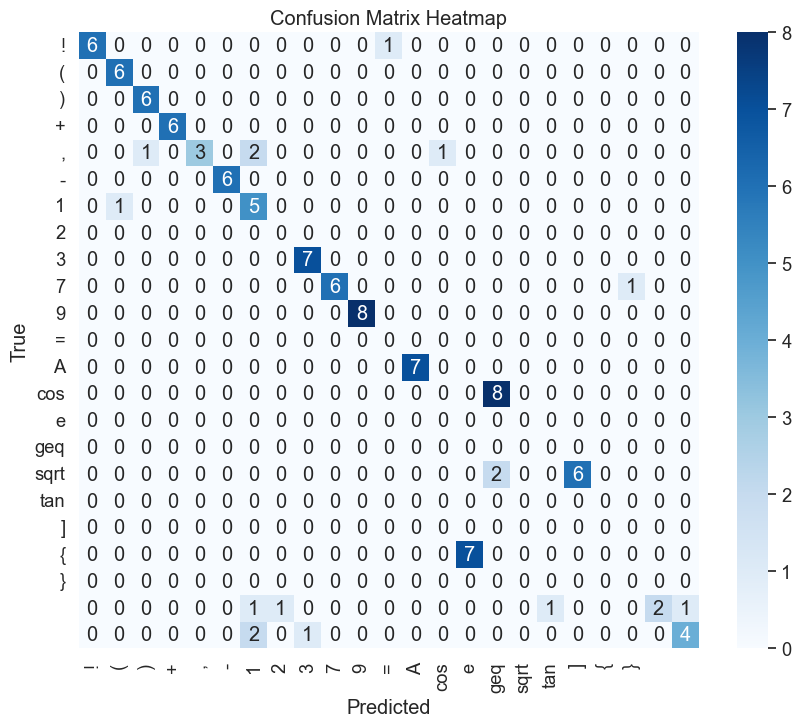

In [67]:
# to better visualize confusion matrix

# Replace this with your class labels
class_labels = [key for key, value in class_labels_dict.items() if value in np.unique(predicted_labels_test)]

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

In [37]:
print("Confusion Matrix Report")
print(report_test)

Confusion Matrix Report
Class !: Correct 6/7 | Wrong: 1
Class (: Correct 6/6 | Wrong: 0
Class ): Correct 6/6 | Wrong: 0
Class +: Correct 6/6 | Wrong: 0
Class ,: Correct 3/7 | Wrong: 4
Class -: Correct 6/6 | Wrong: 0
Class 1: Correct 5/6 | Wrong: 1
Class 3: Correct 7/7 | Wrong: 0
Class 7: Correct 6/7 | Wrong: 1
Class 9: Correct 8/8 | Wrong: 0
Class A: Correct 7/7 | Wrong: 0
Class X: Correct 0/7 | Wrong: 7
Class cos: Correct 0/8 | Wrong: 8
Class sin: Correct 0/8 | Wrong: 8
Class {: Correct 2/6 | Wrong: 4
Class }: Correct 4/7 | Wrong: 3



In [38]:
print("Predicted vs Actual Test")
print(predicted_report_test)

Predicted vs Actual Test
Predicted: !, Actual: !, Result: correct
Predicted: =, Actual: !, Result: wrong
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: !, Actual: !, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: (, Actual: (, Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: ), Actual: ), Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: +, Actual: +, Result: correct
Predicted: +, Actual: +, Result: c